In [67]:
import numpy as np
import torch
import torchvision

from torchvision.datasets import CIFAR100

In [59]:
CIFAR100_RGB_MEAN = (0.5074, 0.4867, 0.4411)
CIFAR100_RGB_STD = (0.2675, 0.2565, 0.2761)

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize(mean=CIFAR100_RGB_MEAN, std=CIFAR100_RGB_STD)
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize(mean=CIFAR100_RGB_MEAN, std=CIFAR100_RGB_STD)
])

In [60]:
train_data = CIFAR100(download=True, root='data', transform=train_transform)
test_data = CIFAR100(root='data', train=False, transform=test_transform)

Files already downloaded and verified


In [61]:
import json

CIFAR100_LABELMAP_PATH = "cifar100_labels.json"


def parse_json(path):
    with open(path, "rt") as f:
        return json.load(f)

LABEL_MAP = {int(k): v for k, v in parse_json(CIFAR100_LABELMAP_PATH).items()}

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt


def show_sample(data_sample):
    img, label = data_sample
    img = img.numpy()
    label = LABEL_MAP[label]
    img = np.transpose(img, [1, 2, 0])  # CHW -> HWC
    
    fig, ax = plt.subplots(1)
    ax.imshow(img, interpolation='bilinear')
    ax.text(5, img.shape[0] - 3, f'Class: "{label}"', bbox={'facecolor': 'white', 'pad': 10})

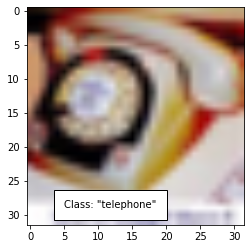

In [92]:
show_sample(train_data[5])